In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# always useful
import numpy as np
import scipy as sp
import seaborn as sns
import math
import pandas as pd
from scipy import linalg as la
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from matplotlib import pylab
import scipy.optimize
from  scipy import fftpack

from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
from scipy.stats.distributions import norm

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [2]:
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
cprob = (np.arange(years_nb, dtype=np.float32) + 1)/(years_nb + 1)
sorted_max_speeds = np.sort(max_speeds)
quantile_func = UnivariateSpline(cprob, sorted_max_speeds)
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)
print('Maximum wind speed occurring in 50 years =',fifty_wind)

Maximum wind speed occurring in 50 years = 32.97989825386221


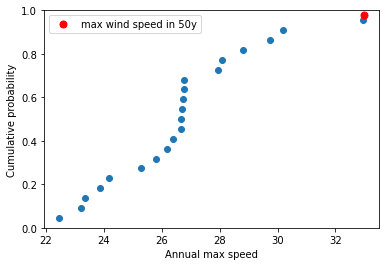

In [3]:
plt.figure(figsize=(6, 4))
plt.scatter(sorted_max_speeds, cprob)
plt.plot([fifty_wind], [fifty_prob], 'o', ms=7., mfc='r',mec='r', label = 'max wind speed in 50y')
#plt.plot([fifty_wind, fifty_wind], [0, fifty_prob], 'k--')
plt.xlabel('Annual max speed')
plt.ylabel('Cumulative probability')
plt.ylim([0,1])
plt.legend(loc='best')
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

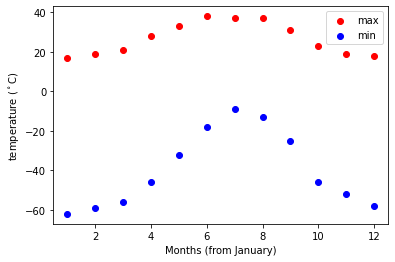

In [4]:
max_temp = np.array([ 17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.linspace(1,12,12) # from January
plt.figure(figsize=(6, 4))
plt.scatter(months, max_temp, c='r',label='max')
plt.scatter(months,min_temp, c='b',label='min')
plt.xlabel('Months (from January)')
plt.ylabel('temperature ($^\circ$C)')
plt.xlim([0.5,12.5])
plt.legend(loc='best')
plt.show()

In [5]:
def yearly_temps(times, avg, ampl, time_offset):
    return (avg+ampl*np.cos((times + time_offset)*2*np.pi/times.max()))

res_max, cov_max = curve_fit(yearly_temps, months,max_temp)
res_min, cov_min = curve_fit(yearly_temps, months,min_temp)

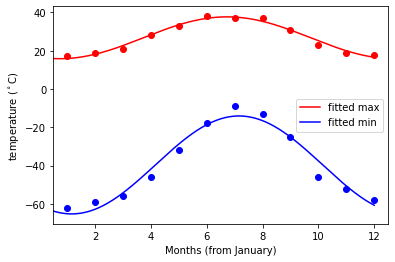

time offset for max 17.2765199499975
time offset for min 46.84396351410324


In [6]:
days = np.linspace(0, 12, num=365)
plt.figure(figsize=(6, 4))
plt.scatter(months, max_temp, c='r')
plt.plot(days, yearly_temps(days, *res_max), 'r-',label='fitted max')
plt.scatter(months,min_temp, c='b')
plt.plot(days, yearly_temps(days, *res_min), 'b-',label='fitted min')
plt.xlabel('Months (from January)')
plt.ylabel('temperature ($^\circ$C)')
plt.xlim([0.5,12.5])
plt.legend(loc='best')
plt.show()
print('time offset for max',res_max[2])
print('time offset for min',res_min[2])

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


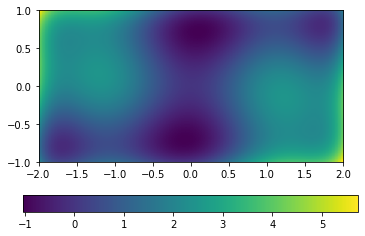

In [7]:
def f(x):
    return (4 - 2.1 * x[0]**2 + x[0]**4 / 3) * x[0]**2 + x[0] * x[1] + (4 * x[1]**2 - 4) * x[1]**2

x = np.linspace(-2,2,101)
y = np.linspace(-1,1,101)
xv, yv = np.meshgrid(x, y)
im = pylab.imshow(f(np.array([xv,yv])), extent = [-2,2,-1,1])
plt.colorbar(im, orientation='horizontal')
plt.show(im)

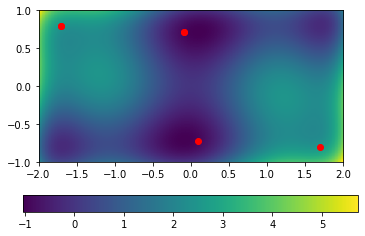

There are 4 minima


In [8]:
m1 = scipy.optimize.minimize(f,x0 = (-1.5,-0.75))
m2 = scipy.optimize.minimize(f,x0 = (0,-0.75))
m3 = scipy.optimize.minimize(f,x0 = (0,0.75))
m4 = scipy.optimize.minimize(f,x0 = (0.75,1.75))
m5 = scipy.optimize.minimize(f,x0 = (-1.25,0))
m6 = scipy.optimize.minimize(f,x0 = (1.25,0))

im = pylab.imshow(f(np.array([xv,yv])), extent = [-2,2,-1,1])
plt.scatter(m1.x[0],m1.x[1], c = 'r')
plt.scatter(m2.x[0],m2.x[1], c = 'r')
plt.scatter(m3.x[0],m3.x[1], c = 'r')
plt.scatter(m4.x[0],m4.x[1], c = 'r')
plt.scatter(m5.x[0],m5.x[1], c = 'r')
plt.scatter(m6.x[0],m6.x[1], c = 'r')
plt.colorbar(im, orientation='horizontal')
plt.show()
print('There are 4 minima')

In [9]:
fmin = scipy.optimize.minimize(f,x0 = (0,0))
print('If initial guess is (0,0) we get a minima in',fmin.x,'and the correspondng value of f is',f(fmin.x), '. Problably (0,0) is a saddle point.')

If initial guess is (0,0) we get a minima in [0. 0.] and the correspondng value of f is 0.0 . Problably (0,0) is a saddle point.


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

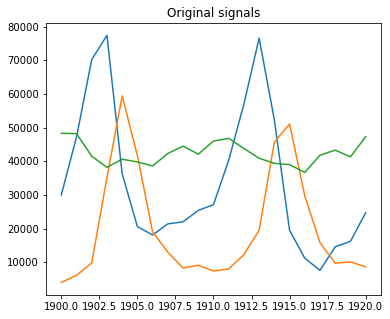

In [10]:
file = np.loadtxt("populations.txt")
time_vec = file[::,0:1:]
sig = file[::,1::]
#print('time_vec','\n',time_vec)
#print('signals','\n',sig)
plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig)
plt.title('Original signals')
plt.show()

C:\Users\tomso\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\tomso\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\tomso\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


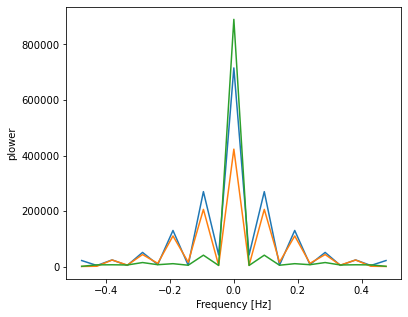

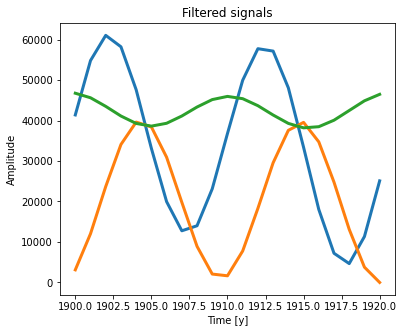

In [11]:
# The FFT of the signal
sig_fft0 = fftpack.fft(sig[:,0])
sig_fft1 = fftpack.fft(sig[:,1])
sig_fft2 = fftpack.fft(sig[:,2])

# And the power (sig_fft is of complex dtype)
power0 = np.abs(sig_fft0)
power1 = np.abs(sig_fft1)
power2 = np.abs(sig_fft2)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(time_vec.size, d=1)

# Plot the FFT power
pwplt0 = np.concatenate([power0[11:],power0[0:11]])
pwplt1 = np.concatenate([power1[11:],power1[0:11]])
pwplt2 = np.concatenate([power2[11:],power2[0:11]])
sample_freq_sort = np.sort(sample_freq)
plt.figure(figsize=(6, 5))
plt.plot(sample_freq_sort,pwplt0)
plt.plot(sample_freq_sort,pwplt1)
plt.plot(sample_freq_sort,pwplt2)
#plt.plot(sample_freq[:11],power0[:11],c='b')
#plt.plot(sample_freq[11:],power0[11:],c='b')
#plt.plot(sample_freq[:11],power1[:11], c='g')
#plt.plot(sample_freq[11:],power1[11:],c='g')
#plt.plot(sample_freq[:11],power2[:11], c='orange')
#plt.plot(sample_freq[11:],power2[11:], c='orange')
plt.xlabel('Frequency [Hz]')
plt.ylabel('plower')

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]

peak_freq0 = freqs[power0[pos_mask].argmax()]
high_freq_fft0 = sig_fft0.copy()
high_freq_fft0[np.abs(sample_freq) > peak_freq0] = 0
filtered_sig0 = fftpack.ifft(high_freq_fft0)

peak_freq1 = freqs[power1[pos_mask].argmax()]
high_freq_fft1 = sig_fft1.copy()
high_freq_fft1[np.abs(sample_freq) > peak_freq1] = 0
filtered_sig1 = fftpack.ifft(high_freq_fft1)

peak_freq2 = freqs[power2[pos_mask].argmax()]
high_freq_fft2 = sig_fft2.copy()
high_freq_fft2[np.abs(sample_freq) > peak_freq2] = 0
filtered_sig2 = fftpack.ifft(high_freq_fft2)


plt.figure(figsize=(6, 5))
plt.plot(time_vec, filtered_sig0, linewidth=3)
plt.plot(time_vec, filtered_sig1, linewidth=3)
plt.plot(time_vec, filtered_sig2, linewidth=3)
plt.xlabel('Time [y]')
plt.ylabel('Amplitude')
plt.title('Filtered signals')
plt.show()

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

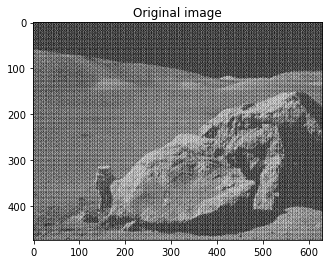

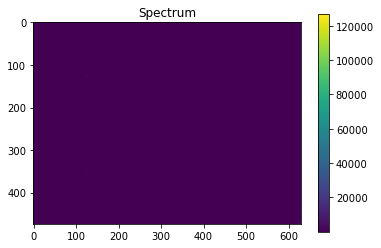

The values of the spectrum are all similar and we cannot perceive the peaks.


In [12]:
image = pylab.imread("moonlanding.png")
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()

spectrum = fftpack.fft2(image)
plt.imshow(np.abs(spectrum))
plt.colorbar(orientation='vertical')
plt.title("Spectrum")
plt.show()
print('The values of the spectrum are all similar and we cannot perceive the peaks.')

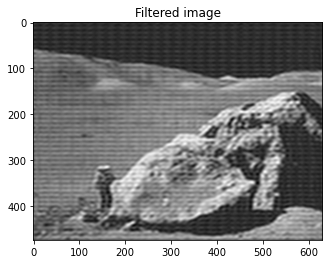

In [13]:
fshift = np.fft.fftshift(spectrum)
rows = np.size(image, 0) #taking the size of the image
cols = np.size(image, 1)
crow, ccol = rows/2, cols/2

original = np.copy(fshift)
fshift[int(crow)-50:int(crow)+50, int(ccol)-50:int(ccol)+50] = 0
f_ishift= np.fft.ifftshift(original - fshift)

img_back = np.fft.ifft2(f_ishift) # shift for centering 0.0 (x,y)
img_back = np.abs(img_back)
plt.imshow(img_back, cmap='gray')
plt.title('Filtered image')
plt.show()